In [26]:
import numpy as np
import datetime as dt

import scipy.signal as ss
import matplotlib.pyplot as plt

import pyxu.operator as pxop
import pyxu.opt.stop as pxos

import pyfwl

# Simulate the problem

In [27]:
seed = 42
rng = np.random.default_rng(seed)

In [48]:
N = 100
k = 10
L = 3 * k
psnrdb = 10

sigma = 2
Nl = N + 6 * int(sigma)

convop = 2 * pxop.Gaussian((Nl, ), sigma=sigma)
samples = rng.choice(Nl, size=L, replace=False)
S = pxop.SubSample((Nl, ), samples)

fOp = S * convop
fOp.lipschitz = fOp.estimate_lipschitz(method='svd', tol=1.e-2)

In [29]:
supp = rng.choice(N, size=k, replace=False) + 3 * int(sigma)
x = np.zeros(N + 6 * int(sigma))
x[supp] = rng.uniform(2, 6, size=k)

g = convop(x)
noiselessy = fOp(x)
std = np.max(np.abs(noiselessy)) * 10 ** (-psnrdb / 20)
noise = rng.normal(0, std, size=L)

y = noiselessy + noise

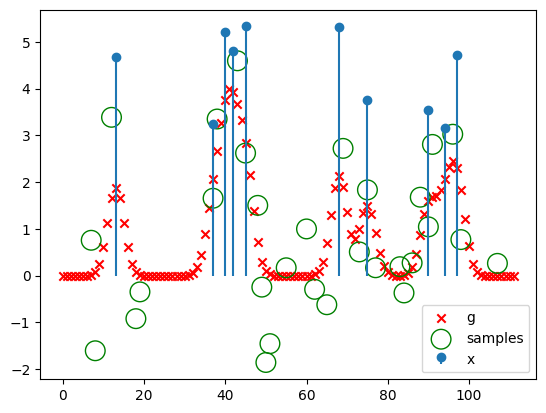

In [30]:
plt.figure()
m, s, b = plt.stem(np.where(x>0)[0], x[x>0], label='x')
b._visible = False
plt.scatter(np.arange(Nl), g, label='g', marker='x', color='r')
plt.scatter(samples, y, label='samples', marker='o', color='none', edgecolors='g', s=200)
plt.legend()
plt.show()

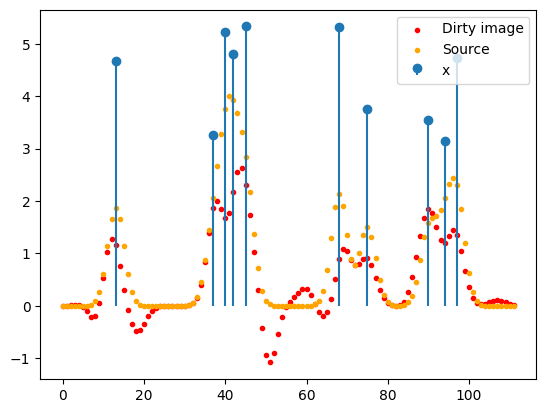

In [31]:
## Dual certificate
d = fOp.adjoint(y)

plt.figure()
plt.scatter(np.arange(Nl), d, marker='.', color='r', label="Dirty image")
plt.scatter(np.arange(Nl), g, marker='.', color='orange', label="Source")
_, _, b = plt.stem(np.where(x>0)[0], x[x>0], label='x')
b._visible = False
plt.legend()
plt.show()

# Solve with PFW

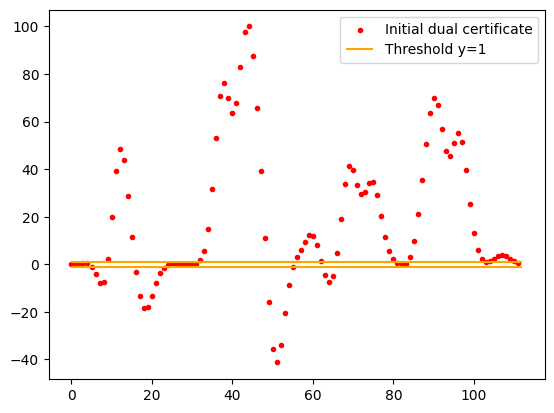

In [42]:
lambda_factor = 0.01
lambda_ = lambda_factor * np.max(np.abs(d))

eps = 1e-5
min_iterations = 10

# plot dual certificate at beginning
plt.figure()
plt.scatter(np.arange(Nl), d/lambda_, marker='.', color='r', label="Initial dual certificate")
plt.hlines([-1, 1], 0, Nl, color='orange', label="Threshold y=1")
plt.legend()
plt.show()

In [33]:
stop_crit = pxos.RelError(
    eps=eps,
    var="objective_func",
    f=None,
    norm=2,
    satisfy_all=True,
)

# Minimum number of iterations
min_iter = pxos.MaxIter(n=min_iterations)
#Maximum runtime
tmax = 15
# track DCV
track_dcv = pxos.AbsError(eps=1e-10, var="dcv", f=None, norm=2, satisfy_all=True)
stop_crit = (min_iter & stop_crit) | pxos.MaxDuration(t=dt.timedelta(seconds=tmax)) | track_dcv

## Regular PFW

In [34]:
pfw = pyfwl.PFWLasso(y, fOp, lambda_,
                     ms_threshold=0.9,
                     final_correction_prec=eps)

pfw.fit(stop_crit=stop_crit, verbose=50,
        # diff_lipschitz=lip**2,
        # positivity_constraint=True,
        precision_rule=lambda k : 10**(-k/10))

Computation of diff_lipschitz takes 0.1859
INFO -- [2024-01-18 10:26:50.373910] Iteration 0
	iteration: 0
	N_iter: 1.0
	RelError[objective_func]: 0.0
	duration: 0.032228
	AbsError[dcv]: inf
	Memorize[objective_func]: 49.915493410760256
INFO -- [2024-01-18 10:26:50.872466] Iteration 10
	iteration: 10
	N_iter: 11.0
	RelError[objective_func]: 0.04935168146159075
	duration: 0.530808
	AbsError[dcv]: 15.717907196399135
	Memorize[objective_func]: 9.135430536224147
INFO -- [2024-01-18 10:26:51.786116] Iteration 20
	iteration: 20
	N_iter: 21.0
	RelError[objective_func]: 0.002974721431577566
	duration: 1.44448
	AbsError[dcv]: 2.4367089123732684
	Memorize[objective_func]: 4.590967322531981
INFO -- [2024-01-18 10:26:53.645130] Iteration 30
	iteration: 30
	N_iter: 31.0
	RelError[objective_func]: 0.006394778553358098
	duration: 3.303517
	AbsError[dcv]: 1.3571674363001889
	Memorize[objective_func]: 3.8668289951000707
INFO -- [2024-01-18 10:26:55.784872] Iteration 40
	iteration: 40
	N_iter: 41.0
	RelE

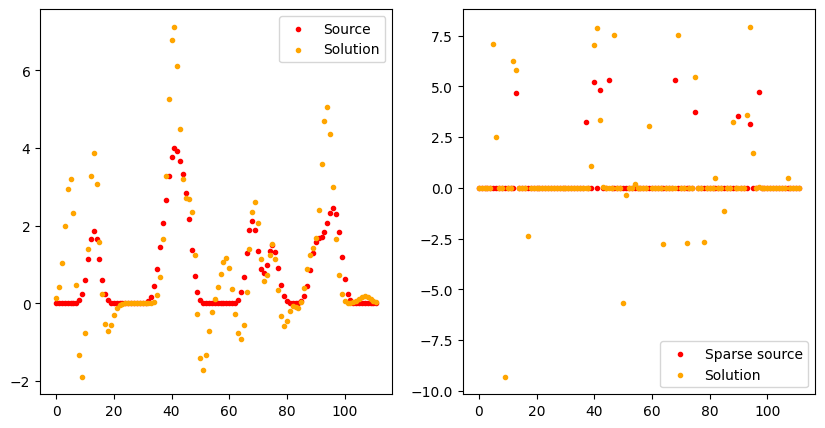

In [35]:
sol = pfw.stats()[0]['x']

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(np.arange(Nl), g, marker='.', color='r', label="Source")
plt.scatter(np.arange(Nl), convop(sol), marker='.', color='orange', label="Solution")
plt.legend()

plt.subplot(122)
plt.scatter(np.arange(Nl), x, marker='.', color='r', label="Sparse source")
plt.scatter(np.arange(Nl), sol, marker='.', color='orange', label="Solution")
plt.legend()
plt.show()

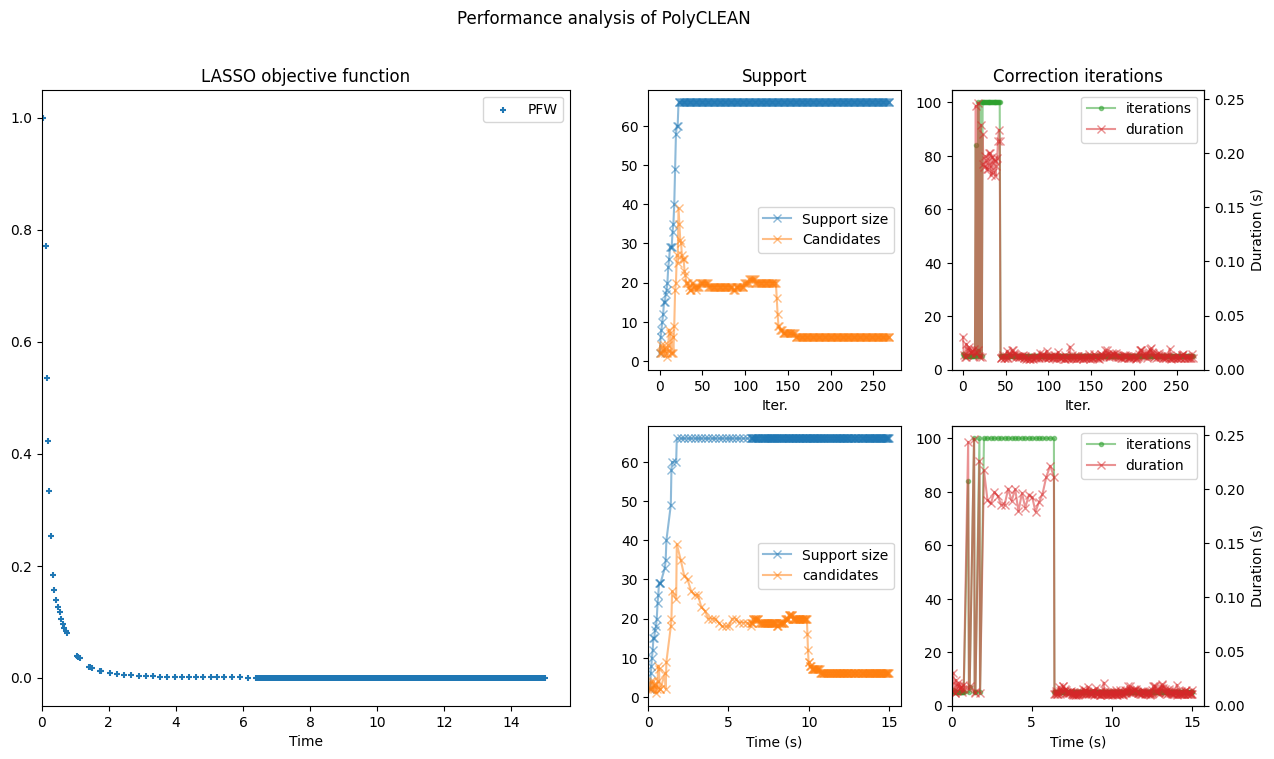

In [36]:
pfw.diagnostics()

## Solve with LocalMaxPFW

In [37]:
from pyfwl import LocalMaxPFW

lmpfw = LocalMaxPFW(y, fOp, lambda_,
                     final_correction_prec=eps)

lmpfw.fit(stop_crit=stop_crit, verbose=50,
        # diff_lipschitz=lip**2,
        # positivity_constraint=True,
        precision_rule=lambda k : 10**(-k/10))


Computation of diff_lipschitz takes 0.2887
INFO -- [2024-01-18 10:27:07.206326] Iteration 0
	iteration: 0
	N_iter: 1.0
	RelError[objective_func]: 0.0
	duration: 0.029936
	AbsError[dcv]: inf
	Memorize[objective_func]: 49.915493410760256
INFO -- [2024-01-18 10:27:07.639579] Iteration 10
	iteration: 10
	N_iter: 11.0
	RelError[objective_func]: 0.03383194821153685
	duration: 0.463296
	AbsError[dcv]: 10.01616166238101
	Memorize[objective_func]: 7.213776067950015
INFO -- [2024-01-18 10:27:08.251454] Iteration 20
	iteration: 20
	N_iter: 21.0
	RelError[objective_func]: 0.002840435151591983
	duration: 1.075187
	AbsError[dcv]: 3.042899752976839
	Memorize[objective_func]: 4.7942448900079295
INFO -- [2024-01-18 10:27:10.051777] Iteration 30
	iteration: 30
	N_iter: 31.0
	RelError[objective_func]: 0.008346151229690079
	duration: 2.875519
	AbsError[dcv]: 1.5103124940589805
	Memorize[objective_func]: 3.891017765529103
INFO -- [2024-01-18 10:27:12.262743] Iteration 40
	iteration: 40
	N_iter: 41.0
	RelEr

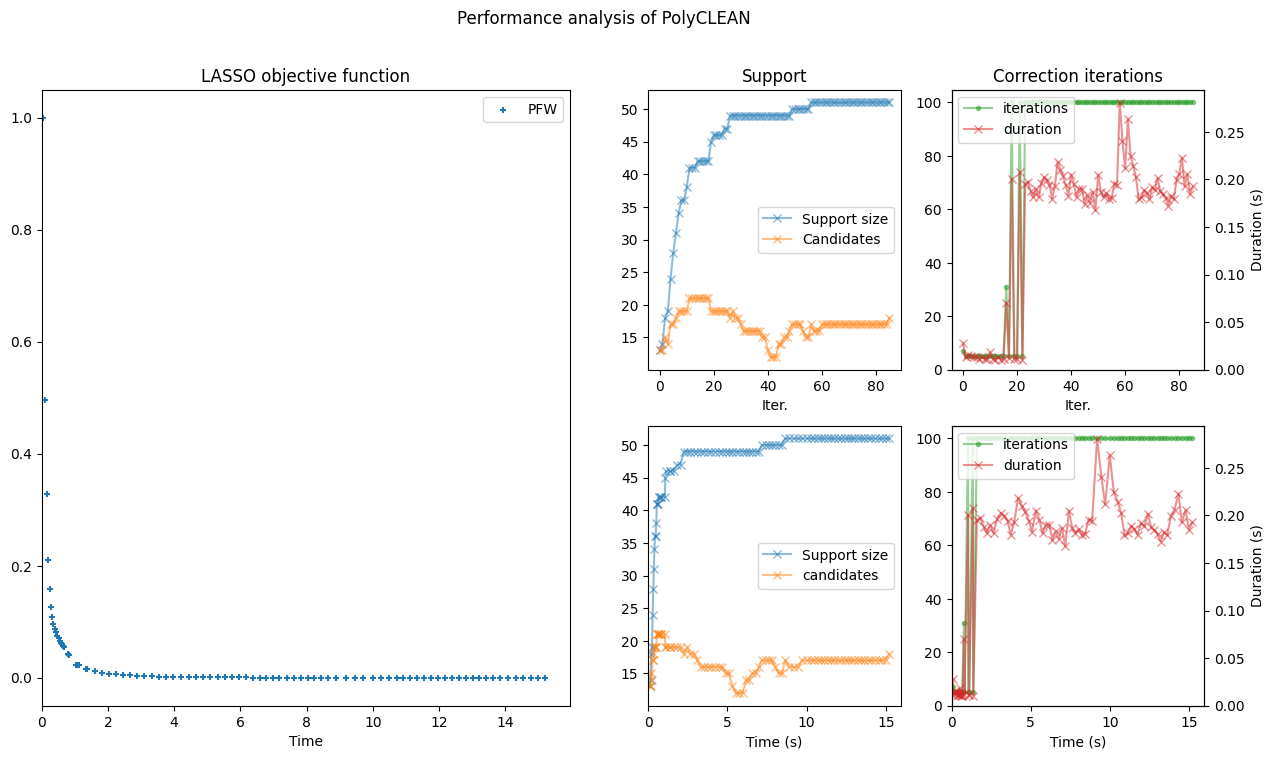

In [38]:
lmpfw.diagnostics()

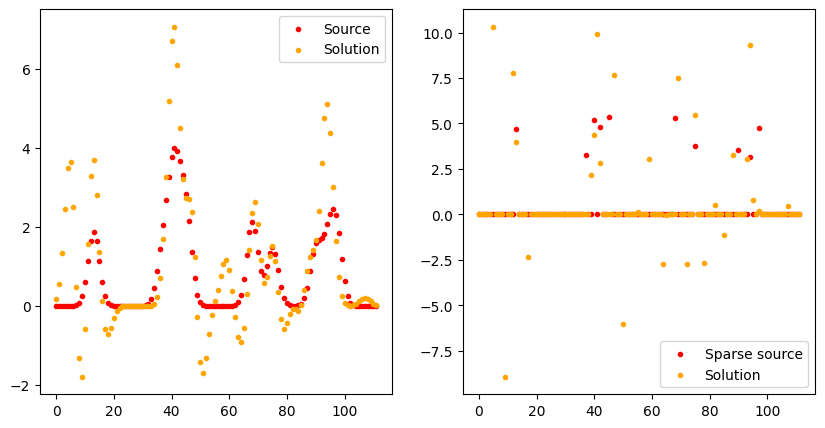

In [39]:
sol = lmpfw.stats()[0]['x']

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(np.arange(Nl), g, marker='.', color='r', label="Source")
plt.scatter(np.arange(Nl), convop(sol), marker='.', color='orange', label="Solution")
plt.legend()

plt.subplot(122)
plt.scatter(np.arange(Nl), x, marker='.', color='r', label="Sparse source")
plt.scatter(np.arange(Nl), sol, marker='.', color='orange', label="Solution")
plt.legend()
plt.show()

## Solve with PGD

In [40]:
from pyxu.opt.solver import PGD

# Explicit definition of the objective function for APGD
data_fid = 0.5 * pxop.SquaredL2Norm(dim=fOp.shape[0]).argshift(-y) * fOp
regul = lambda_ * pxop.L1Norm(N)

print("Solving with APGD: ...")
pgd = PGD(data_fid, regul, verbosity=50)
pgd.fit(
    x0=np.zeros(Nl, dtype="float64"),
    stop_crit=(min_iter & pgd.default_stop_crit()) | pxos.MaxDuration(t=dt.timedelta(seconds=tmax)),
    track_objective=True,
    tau=1 / lip ** 2,
)
sol_apgd = pgd.stats()[0]["x"]

Solving with APGD: ...
INFO -- [2024-01-18 10:27:23.820720] Iteration 0
	iteration: 0
	N_iter: 1.0
	RelError[x]: 0.0
	duration: 0.00252
	Memorize[objective_func]: 49.915493410760256
INFO -- [2024-01-18 10:27:23.979951] Iteration 50
	iteration: 50
	N_iter: 51.0
	RelError[x]: 0.009807652889236232
	duration: 0.161679
	Memorize[objective_func]: 4.814045990505827
INFO -- [2024-01-18 10:27:24.130827] Iteration 100
	iteration: 100
	N_iter: 101.0
	RelError[x]: 0.004934825181082804
	duration: 0.312668
	Memorize[objective_func]: 4.233054704070928
INFO -- [2024-01-18 10:27:24.284569] Iteration 150
	iteration: 150
	N_iter: 151.0
	RelError[x]: 0.0030744589613579437
	duration: 0.466387
	Memorize[objective_func]: 4.0353584260493385
INFO -- [2024-01-18 10:27:24.421908] Iteration 200
	iteration: 200
	N_iter: 201.0
	RelError[x]: 0.002624015551411086
	duration: 0.603763
	Memorize[objective_func]: 3.932436035687691
INFO -- [2024-01-18 10:27:24.558452] Iteration 250
	iteration: 250
	N_iter: 251.0
	RelError

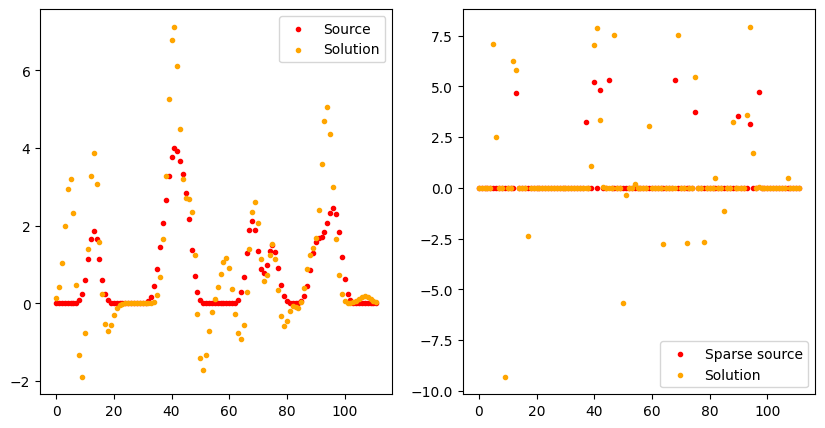

In [41]:
sol = pfw.stats()[0]['x']

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(np.arange(Nl), g, marker='.', color='r', label="Source")
plt.scatter(np.arange(Nl), convop(sol), marker='.', color='orange', label="Solution")
plt.legend()

plt.subplot(122)
plt.scatter(np.arange(Nl), x, marker='.', color='r', label="Sparse source")
plt.scatter(np.arange(Nl), sol, marker='.', color='orange', label="Solution")
plt.legend()
plt.show()